In [3]:
import numpy as np
import pandas as pd
#import scipy.spatial as spatial
#import codecs
import os.path
import matplotlib.pyplot as plt
#import matplotlib.gridspec as gridspec
from scipy.optimize import curve_fit
import time
import itertools

from class_stat import FourierTransform

#run_path = os.path.join('D:/Bubble_Thermal', 'data_collect128_2.1/raw_data_exp/')
run_path = os.path.join('D:/Bubble_Thermal', 'non_random_test_exp/raw_data_128/')
#run_path = os.path.join('F:/ManualBackup/Bubble_Thermal', 'data_collect128_2/raw_data_ensemble/run.232/')

vec_ids = ['Bx', 'By', 'Bz']
#var_id is only used to save data.
#I do not open the energy density files.
var_id = 'EMB'

bins = 60
nSize = 128
DX = 0.25

# Higgs mass mH^2 = 4*\lambda*\eta^2
eta = 6.0
mH = 2 * 0.129**0.5 * eta

DT = DX / 4
L = nSize*DX
LatV = L**3

os.path.exists(run_path)

True

In [2]:
# spectrum plot for ensemble data
# average over the exponents of the power-law spectra

run_ids = ['run.'+ str(x) for x in [2501] ]
spoints = ['t_' + str(x) for x in range(28, 1000, 1000)]
ensemble_size = 20
df = pd.DataFrame(columns = run_ids)
    
for spoint in spoints:
    print('Processing ', spoint, ' ...')
    max_bins = []
    mean_bins = []
    magnetic = []
    asc_ks = []
    max_bins_std = []
    mean_bins_std = []
    magnetic_std = []
    asc_ks_std = []
    for run_id in run_ids:
        plt.figure(figsize=(6,4))
        # quantities needed to do average for each sample
        max_bins_ens = []
        mean_bins_ens = []
        asc_ks_ens = []
        magnetic_ens = []
        for ens in range(1, ensemble_size+1):
            f = FourierTransform(run_path, run_id + str(ens).zfill(3), nSize, stop_point = spoint);
            f.fft_vector(vec_ids);
            f.fft_energy_spec();
            radial = f.fft_radial(f.k_energy, bins)
            # proper normalization: such that radial.sum() == total energy
            radial = radial / (2.0*(nSize/DX)**3)
            # normalize to energy density in units of m_H^4
            radial = radial / (LatV*mH**4)
            rbins = f.fft_bins(bins);# return the bin labels
            plt.bar(rbins, np.absolute(radial), align='center', width = 0.01) # A bar chart
            plt.xlabel('K')
            plt.ylabel('E_M')

            try:
                fit_param_asc = f.fit_powerlaw(rbins, radial, sample_number = None, fig = plt.gcf())
            except:
                fit_param_asc = [0,0]
            try:
                fit_param_desc = f.fit_powerexp(rbins, radial, fig = plt.gcf())
            except:
                fit_param_desc = [0,0]
            max_bins_ens.append(rbins[f.fft_max_bin(radial)[1]])
            mean_bins_ens.append(f.k_mean(f.k_energy)) 
            magnetic_ens.append(radial.sum())
            asc_ks_ens.append(fit_param_asc[0])
            plt.close()
        
        max_bins.append( np.mean(max_bins_ens) )
        mean_bins.append( np.mean(mean_bins_ens) )
        magnetic.append( np.mean(magnetic_ens) )
        asc_ks.append( np.mean(asc_ks_ens) )
        max_bins_std.append( np.std(max_bins_ens) )
        mean_bins_std.append( np.std(mean_bins_ens) )
        magnetic_std.append( np.std(magnetic_ens) )
        asc_ks_std.append( np.std(asc_ks_ens) )
    
    tmp = pd.DataFrame(data = [mean_bins, mean_bins_std, max_bins, max_bins_std, magnetic, magnetic_std, asc_ks, asc_ks_std], columns = run_ids, \
                       index = [[spoint]*8,
                                ['k_mean', 'k_mean_std', 'k_max', 'k_max_std','MagE', 'MagE_std', 'asc_k', 'asc_k_std']])
    df = pd.concat([df, tmp])

df.index = pd.MultiIndex.from_tuples(df.index)
df.to_csv('temp.csv')


Processing  t_28  ...


FileNotFoundError: [Errno 2] No such file or directory: 'D:/Bubble_Thermal\\non_random_test_exp/raw_data_128/run.2501001.t_28.Bx.datfast'

In [14]:
# compute and plot the spectrum for a list of run_ids and stop points.
# This is NOT for ensemble data
#run_ids = ['run.'+ str(x) for x in [232010] ]
#spoints = ['t_' + str(int(x)) for x in np.hstack( (np.linspace(10,100,10), np.linspace(100,3000,30)) ) ]
spoints = ['t_' + str(x) for x in range(124, 1000, 20)]
run_ids = ['run.2505']
#spoints = ['0.25']
df = pd.DataFrame(columns = run_ids)

for spoint in spoints:
    print('Processing ', spoint, ' ...')
    mean_bins = []
    max_bins = []
    magnetic = []
    asc_ks = []
    for run_id in run_ids:
        plt.figure(figsize=(6,4))
        f = FourierTransform(run_path, run_id, nSize, stop_point = spoint);
        f.fft_vector(vec_ids);
        f.fft_energy_spec();
        #f.build_kdtree();
        #f_radial = f.fft_radial_kdtree(f.k_energy ,bins)
        radial = f.fft_radial(f.k_energy, bins)
        #proper normalization: such that radial.sum() == total energy
        radial = radial / (2.0*(nSize/DX)**3)
        # normalize to energy density in units of m_H^4
        radial = radial / (LatV*mH**4)
        rbins = f.fft_bins(bins);# return the bin labels
        plt.bar(rbins, np.absolute(radial), align='center', width = 0.007) # A bar chart
        plt.xlabel('K')
        plt.ylabel('E_M')
        ##fig2.savefig(run_id + '.' + var_id + '.fftr.png')
        
        '''
        fit_params = f.two_parts_fit_powerlaw(rbins, radial, plt.gcf())
        max_val, max_bin = f.fft_max_bin(radial)
        max_bin_val = rbins[max_bin]
        max_text = 'k_asc = ' + str('%.4f' % fit_params[0][0]) + \
                  '\n k_desc = ' + str('%.4f' % fit_params[1][0]) + \
                  '\n k_max = ' + str('%.4f' % max_bin_val) + \
                     '\n val = ' + str('%.4E' % max_val)
        ax = plt.gca()
        ax.text(0.95, 0.95, max_text, \
                 verticalalignment='top', horizontalalignment='right', transform=ax.transAxes)
        ax.set_ylim([0, max_val*1.2])
        fig = plt.gcf()
        fig.savefig(run_id + '.' + var_id + '.' + str(spoint) + '.fftr.png')
        '''
        #fig = plt.figure(figsize=(6,4))
        
        try:
            fit_param_asc = f.fit_powerlaw(rbins, radial, sample_number = None, fig = plt.gcf())
        except:
            print('Power-law fit failed')
            fit_param_asc = [0,0]
        try:
            fit_param_desc = f.fit_powerexp(rbins, radial, plt.gcf())
        except:
            fit_param_desc = [0,0]
        
        max_val, max_bin = f.fft_max_bin(radial)
        max_bin_val = rbins[max_bin]
        
        #y=k*x^a*exp(-b*x)
        
        max_text = 'asc_k = ' + str('%.4f' % fit_param_asc[0]) + \
                  '\n desc_a = ' + str('%.4f' % fit_param_desc[0]) + \
                  '\n desc_b = ' + str('%.4f' % fit_param_desc[1]) + \
                  '\n k_max = ' + str('%.4f' % max_bin_val) + \
                     '\n val = ' + str('%.4E' % max_val)
        ax = plt.gca()
        ax.text(0.95, 0.95, max_text, \
                 verticalalignment='top', horizontalalignment='right', transform=ax.transAxes)
        #ax.set_ylim([0, max_val*1.2])
        ax.set_ylim([0, 1e-3])
        
        fig = plt.gcf()
        plt.close()
        fig.savefig(run_id + '.' + var_id + '.' + str(spoint) + '.fftr.png')
        mean_bins.append(f.k_mean(f.k_energy))
        #mean_bins.append(f.mean_bin(rbins, radial))
        magnetic.append(radial.sum())
        max_bins.append(max_bin_val)
        asc_ks.append(fit_param_asc[0])
    
    tmp = pd.DataFrame(data = [mean_bins, max_bins, magnetic, asc_ks], columns = run_ids, \
                       index = [[spoint]*4,['k_mean', 'k_max', 'MagE', 'asc_k']])
    df = pd.concat([df, tmp])

df.index = pd.MultiIndex.from_tuples(df.index)
df.to_csv('temp.csv')

Processing  t_124  ...
Processing  t_144  ...
Processing  t_164  ...
Processing  t_184  ...
Processing  t_204  ...
Processing  t_224  ...
Processing  t_244  ...
Processing  t_264  ...
Processing  t_284  ...
Processing  t_304  ...
Processing  t_324  ...
Processing  t_344  ...
Processing  t_364  ...
Processing  t_384  ...
Processing  t_404  ...
Processing  t_424  ...
Processing  t_444  ...
Processing  t_464  ...
Processing  t_484  ...
Processing  t_504  ...
Processing  t_524  ...
Processing  t_544  ...
Processing  t_564  ...
Processing  t_584  ...
Processing  t_604  ...
Processing  t_624  ...
Processing  t_644  ...
Processing  t_664  ...
Processing  t_684  ...
Processing  t_704  ...
Processing  t_724  ...
Processing  t_744  ...
Processing  t_764  ...
Processing  t_784  ...
Processing  t_804  ...
Processing  t_824  ...
Processing  t_844  ...
Processing  t_864  ...
Processing  t_884  ...
Processing  t_904  ...
Processing  t_924  ...
Processing  t_944  ...
Processing  t_964  ...
Processing 

In [6]:
radial.max()

0.00031267337031327052

# plot xlsx data

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
    
def extract_data(xlsx, sheet_name, column_id, 
                 is_std = True, is_kmax = True):
    df = xlsx.parse(sheet_name)
    df_new = pd.DataFrame()
    df.sort_index(inplace = True)
    
    time = df.loc[pd.IndexSlice[:,'k_mean'],'Timestep'].values   
    sort_time = np.argsort(time)
    time = time[sort_time]
    df_new['time'] = time
    
    kmean = df.loc[pd.IndexSlice[:,'k_mean'], column_id].values
    kmean = kmean[sort_time]
    if is_kmax:
        kmax = df.loc[pd.IndexSlice[:,'k_max'], column_id].values
        kmax = kmax[sort_time]
        df_new['kmax'] = kmax
    asck = df.loc[pd.IndexSlice[:,'asc_k'], column_id].values
    asck = asck[sort_time]
    magE = df.loc[pd.IndexSlice[:,'MagE'], column_id].values
    magE = magE[sort_time]
    
    df_new['kmean'] = kmean
    df_new['exponent'] = asck
    df_new['MagE'] = magE
    
    if is_std:
        kmean_std = df.loc[pd.IndexSlice[:,'k_mean_std'], column_id].values
        kmean_std = kmean_std[sort_time]
        if is_kmax:
            kmax_std = df.loc[pd.IndexSlice[:,'k_max_std'], column_id].values
            kmax_std = kmax_std[sort_time]
            df_new['kmax_std'] = kmax_std
        asck_std = df.loc[pd.IndexSlice[:,'asc_k_std'], column_id].values
        asck_std = asck_std[sort_time]
        magE_std = df.loc[pd.IndexSlice[:,'MagE_std'], column_id].values
        magE_std = magE_std[sort_time]
        df_new['kmean_std'] = kmean_std
        df_new['exponent_std'] = asck_std
        df_new['MagE_std'] = magE_std
    return df_new

mH = 2 * 0.129**0.5 * 6.0
DX = 0.25
DT = DX / 4
Nsize = 128
L = Nsize*DX
LatV = L**3

def plot_ens(name, single, ens, single_color, ens_color,
               single_label, ens_label, plot_single = False):
    if plot_single:
        plt.plot(single['time']*DT*mH, single[name], 
                 linestyle = ':', c = single_color,
                 label = single_label)
    plt.plot(ens['time']*DT*mH, ens[name], 
             c = ens_color,
             label = ens_label)
    plt.fill_between(ens['time']*DT*mH, 
                     ens[name] - ens[name+'_std'], ens[name] + ens[name+'_std'], 
                     alpha = 0.3, color = ens_color)
    return None


In [2]:
file_path = os.path.join(os.getcwd(), 'data_collect128_2/test_fft_ensemble_10k.xlsx')
xlsx = pd.ExcelFile(file_path)

# ensemble
ens_212 = extract_data(xlsx, 'ensemble_std.212', 'run.212')
ens_222 = extract_data(xlsx, 'ensemble_std.222', 'run.222')
ens_232 = extract_data(xlsx, 'ensemble_std.232', 'run.232')
ens_234 = extract_data(xlsx, 'ensemble_std.234', 'run.234')

# single
sin_212 = extract_data(xlsx, 'single.212', 'run.212010', is_std = False)
sin_222 = extract_data(xlsx, 'single.222', 'run.222010', is_std = False)
sin_232 = extract_data(xlsx, 'single.232', 'run.232010', is_std = False)
sin_234 = extract_data(xlsx, 'single.234', 'run.234010', is_std = False)

In [17]:
for ens_tmp in [ens_212, ens_222, ens_232, ens_234]:
    eb_2 = ens_tmp.loc[ens_tmp['time'][ens_tmp['time'] == 800].index, 'MagE'].values
    eb_23 = ens_tmp.loc[ens_tmp['time'][ens_tmp['time'] == 9900].index, 'MagE'].values
    print(  (eb_23-eb_2) / eb_2)

[ 1.47066099]
[ 1.56776633]
[ 1.61240349]
[ 1.48880161]


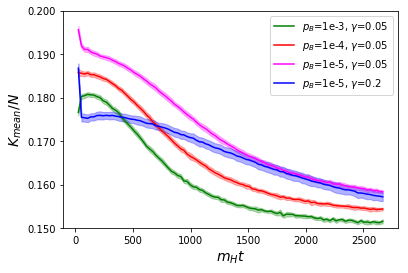

In [34]:
def plot_kmean(single, ens, single_color, ens_color,
               single_label, ens_label):
    plot_ens('kmean', single, ens, single_color, ens_color,
               single_label, ens_label)
    return None
    
plot_kmean(sin_212, ens_212, 'green', 'green', 
           single_label = '',
           ens_label = '$p_B$=1e-3, $\gamma$=0.05')
plot_kmean(sin_222, ens_222, 'red', 'red', 
           single_label = '',
           ens_label = '$p_B$=1e-4, $\gamma$=0.05')
plot_kmean(sin_232, ens_232, 'magenta', 'magenta', 
           single_label = '',
           ens_label = '$p_B$=1e-5, $\gamma$=0.05')
plot_kmean(sin_234, ens_234, 'blue', 'blue', 
           single_label = '',
           ens_label = '$p_B$=1e-5, $\gamma$=0.2') 

plt.ylim([0.15,0.20])
plt.xlabel('$m_Ht$', fontsize = 14)
plt.ylabel('$K_{mean}/N$', fontsize = 14)
plt.legend(loc = 'best')
ax = plt.gca()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
plt.show()

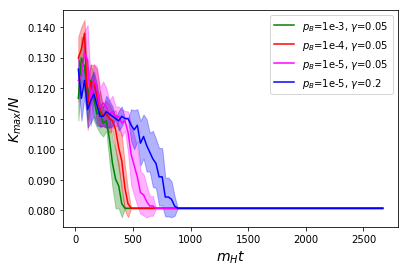

In [33]:
def plot_kmax(single, ens, single_color, ens_color,
               single_label, ens_label):
    plot_ens('kmax', single, ens, single_color, ens_color,
               single_label, ens_label)
    return None

plot_kmax(sin_212, ens_212, 'green', 'green', 
           single_label = '',
           ens_label = '$p_B$=1e-3, $\gamma$=0.05') 
plot_kmax(sin_222, ens_222, 'red', 'red', 
           single_label = '',
           ens_label = '$p_B$=1e-4, $\gamma$=0.05')
plot_kmax(sin_232, ens_232, 'magenta', 'magenta', 
           single_label = '',
           ens_label = '$p_B$=1e-5, $\gamma$=0.05')
plot_kmax(sin_234, ens_234, 'blue', 'blue', 
           single_label = '',
           ens_label = '$p_B$=1e-5, $\gamma$=0.2') 

plt.xlabel('$m_Ht$', fontsize = 14)
plt.ylabel('$K_{max}/N$', fontsize = 14)
#plt.title('K_max vs. time step')
plt.legend(loc = 'best')
ax = plt.gca()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
plt.show()

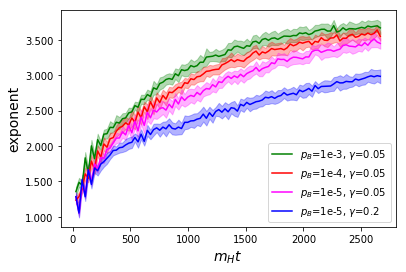

In [31]:
def plot_exponent(single, ens, single_color, ens_color,
                  single_label, ens_label):
    plot_ens('exponent', single, ens, single_color, ens_color,
               single_label, ens_label)
    return None

plot_exponent(sin_212, ens_212, 'green', 'green', 
           single_label = '',
           ens_label = '$p_B$=1e-3, $\gamma$=0.05')
plot_exponent(sin_222, ens_222, 'red', 'red', 
           single_label = '',
           ens_label = '$p_B$=1e-4, $\gamma$=0.05')
plot_exponent(sin_232, ens_232, 'magenta', 'magenta', 
           single_label = '',
           ens_label = '$p_B$=1e-5, $\gamma$=0.05')
plot_exponent(sin_234, ens_234, 'blue', 'blue', 
           single_label = '',
           ens_label = '$p_B$=1e-5, $\gamma$=0.2') 


plt.xlabel('$m_Ht$', fontsize = 14)
plt.ylabel('exponent', fontsize = 14)
#plt.title('Power-law exponent vs. time step')
plt.legend(loc = 'best')
ax = plt.gca()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
plt.show()

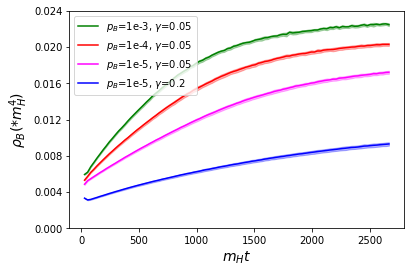

In [43]:
def plot_mage(single, ens, single_color, ens_color,
               single_label, ens_label, plot_single = False):
    if plot_single:
        plt.plot(single['time']*DT*mH, single['MagE']/(LatV*mH**4), 
                 linestyle = ':', c = single_color,
                 label = single_label)
    plt.plot(ens['time']*DT*mH, ens['MagE']/(LatV*mH**4), 
             c = ens_color,
             label = ens_label)
    plt.fill_between(ens['time']*DT*mH, 
                     (ens['MagE'] - ens['MagE'+'_std'])/(LatV*mH**4), (ens['MagE'] + ens['MagE'+'_std'])/(LatV*mH**4), 
                     alpha = 0.3, color = ens_color)
    return None
plot_mage(sin_212, ens_212, 'green', 'green', 
          single_label = '',
           ens_label = '$p_B$=1e-3, $\gamma$=0.05')
plot_mage(sin_222, ens_222, 'red', 'red', 
           single_label = '',
           ens_label = '$p_B$=1e-4, $\gamma$=0.05')
plot_mage(sin_232, ens_232, 'magenta', 'magenta', 
           single_label = '',
           ens_label = '$p_B$=1e-5, $\gamma$=0.05')
plot_mage(sin_234, ens_234, 'blue', 'blue', 
           single_label = '',
           ens_label = '$p_B$=1e-5, $\gamma$=0.2') 

plt.xlabel('$m_Ht$', fontsize = 14)
plt.ylabel('$\\rho_B$(*$m_H^4$)', fontsize = 14)
#plt.title('Magnetic energy vs. time step')
plt.legend(loc = 'best')
ax = plt.gca()
ax.set_yticks(np.linspace(0, 0.024, 7))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
plt.show()

In [26]:
plt.xlim()

(0.0, 1.0)

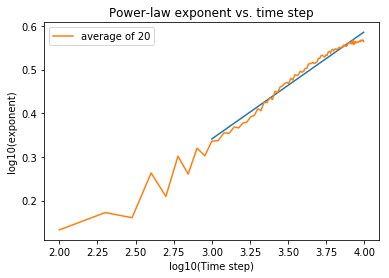

slope =  0.245530952616
intercept =  -0.395426558225
r_value =  0.987677466384


In [8]:
from scipy.stats import linregress
lg_time = np.log10(time)
mask = lg_time >= 3.0
lg_asck = np.log10(asck)
slope, intercept, rval, pval, stderr = linregress(lg_time[mask], lg_asck[mask])
reg_y = slope * lg_time[mask] + intercept
plt.plot(lg_time[mask], reg_y)

plt.plot(lg_time, 
         lg_asck,
         label = 'average of 20')
plt.xlabel('log10(Time step)')
plt.ylabel('log10(exponent)')
plt.title('Power-law exponent vs. time step')
plt.legend(loc = 'best')
plt.show()
print('slope = ', slope)
print('intercept = ', intercept)
print('r_value = ', rval)

In [2]:
# spectrum plot for ensemble data
# average over the mod-square of the fields.

run_ids = ['run.'+ str(x) for x in [212] ]
spoints = ['t_' + str(x) for x in range(4100, 4500, 100)]
ensemble_size = 20
df = pd.DataFrame(columns = run_ids)

for spoint in spoints:
    mean_bins = []
    max_bins = []
    magnetic = []
    asc_ks = []
    for run_id in run_ids:
        plt.figure(figsize=(6,4))
        f = FourierTransform(run_path, run_id, nSize, stop_point = spoint);
        f.fft_ensemble(vec_ids, ensemble_size);
        radial = f.fft_radial(f.k_energy, bins)
        # proper normalization: such that radial.sum() == total energy
        radial = radial / (2.0*(nSize/dx)**3)
        rbins = f.fft_bins(bins);# return the bin labels
        plt.bar(rbins, np.absolute(radial), align='center', width = 0.01) # A bar chart
        plt.xlabel('K')
        plt.ylabel('E_M')
        
        try:
            fit_param_asc = f.fit_powerlaw(rbins, radial, sample_number = None, fig = plt.gcf())
        except:
            fit_param_asc = [0,0]
        try:
            fit_param_desc = f.fit_powerexp(rbins, radial, fig = plt.gcf())
        except:
            fit_param_desc = [0,0]
        
        max_val, max_bin = f.fft_max_bin(radial)
        max_bin_val = rbins[max_bin]
        
        #y=k*x^a*exp(-b*x)
        
        max_text = 'asc_k = ' + str('%.4f' % fit_param_asc[0]) + \
                  '\n desc_a = ' + str('%.4f' % fit_param_desc[0]) + \
                  '\n desc_b = ' + str('%.4f' % fit_param_desc[1]) + \
                  '\n k_max = ' + str('%.4f' % max_bin_val) + \
                     '\n val = ' + str('%.4E' % max_val)
        ax = plt.gca()
        ax.text(0.95, 0.95, max_text, \
                 verticalalignment='top', horizontalalignment='right', transform=ax.transAxes)
        #ax.set_ylim([0, max_val*1.2])
        ax.set_ylim([0, 35000])
        
        fig = plt.gcf()
        fig.savefig(run_id + '.' + var_id + '.' + str(spoint) + '.fftr.png')
        mean_bins.append(f.k_mean(f.k_energy))
        #mean_bins.append(f.mean_bin(rbins, radial))
        magnetic.append(radial.sum())
        max_bins.append(max_bin_val)
        asc_ks.append(fit_param_asc[0])
    
    tmp = pd.DataFrame(data = [mean_bins, magnetic, asc_ks], columns = run_ids, \
                       index = [[spoint, spoint, spoint],['k_mean', 'MagE', 'asc_k']])
    df = pd.concat([df, tmp])

df.index = pd.MultiIndex.from_tuples(df.index)
df.to_csv('temp.csv')